# ASL Sign Language Detection Using ViT

### Relevant Imports

In [1]:
import os
from zipfile import ZipFile, Path
import csv
import pandas as pd
import numpy as np
from skimage import io
from contextlib import contextmanager
from matplotlib import pyplot as plt
import math


import torch
from torch import nn, Tensor
from torch.utils import data as tdata
from torchvision import utils as vutils, transforms as T

In [2]:
# keep this at 0 on windows
num_workers = 0

### Custom Datasets

- Below, we implement custom datasets where we can read directly from zip files without actually unzipping them.

In [3]:
# path of zip file
zip_path = 'archive.zip'

# path of training dir in the zip file
train_path = 'asl_alphabet_train/asl_alphabet_train/'

# file where (path, target will be stored)
info_path = './info.csv'

def get_dirs_and_count(zip_path, dir_path, info_path):
  """Is useful for getting directory list, counts etc

  Args:
      zip_path (str): _description_
      dir_path (str): _description_

  Returns:
      `Tuple[List[str], Dict[str, int], Dict[str, int]]`: \n
      1. List of directories, 2. dictionary that maps those directories to the index in that list, 3. Dictionary that holds `(path, target)`
  """

  with ZipFile(zip_path, 'r') as f:
    path = Path(f, dir_path)

    # stores a `Path` object for each directory in the mentioned `dir_path`
    dirs = [x for x in path.iterdir() if x.is_dir()]

    # stores each file's path to it's target class
    path_to_class = {}

    for i, d in enumerate(dirs):
      # we need to iterate over the files in `d` and write `(file_path, target)`

      for f in d.iterdir():
        path_to_class[f"{train_path}{d.name}/{f.name}"] = i

    # we convert each path like object to the actual directory name
    dirs = [x.name for x in dirs]

    # is like classes_to_idx
    dir_to_i = {d: i for i, d in enumerate(dirs)}

  # below code writes to an info csv in the format `path,target`
  if not os.path.exists(info_path) and info_path is not None:
    with open(info_path, 'w') as f:
      w = csv.writer(f)
      w.writerows(path_to_class.items())

  return dirs, dir_to_i, path_to_class


# print(str(get_dirs_and_count(zip_path, train_path, info_path))[:1000])
class_names, class_to_idx, _ = get_dirs_and_count(zip_path, train_path, info_path)
num_classes = len(class_names)
num_classes


29

In [4]:
class _ImageZipDataset(tdata.Dataset):

  def __init__(self, zip_file: ZipFile, samples, transform=None) -> None:
    self.zip_file = zip_file
    self.samples = samples

    self.transform = transform


  def __getitem__(self, index):
    path, target = self.samples[index]

    with self.zip_file.open(path) as f:
      # sample = Image.open(f).convert('RGB')
      sample = io.imread(f)

    if self.transform is not None:
      sample = self.transform(sample)

    return sample, target

  def __len__(self):
    return len(self.samples)


In [5]:
class ImageZipDatasetWrapper(tdata.Dataset):

  def __init__(self, zip_path, dir_path, info_path, transform=None) -> None:

    if not os.path.exists(zip_path):
      raise FileNotFoundError("Provided zip file does not exist at path")

      
    self.zip_path = zip_path
    self.classes, self.classes_to_idx, _ = get_dirs_and_count(
        zip_path, dir_path, info_path)

    if not os.path.exists(info_path):
      raise FileNotFoundError("CSV File does not exist")
      
    self.samples = self.load_csv(info_path)
    self.transform = transform

  def load_csv(self, info_path):
    return pd.read_csv(info_path).to_numpy()

  @contextmanager
  def dataset(self):
    with ZipFile(self.zip_path, 'r') as z:
      res = _ImageZipDataset(
          zip_file=z,
          samples=self.samples,
          transform=self.transform
      )
      yield res

  def __len__(self):
    return len(self.samples)


In [6]:
mean, std = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
img_size = 128

data_transforms = T.Compose([T.ToTensor(), T.Resize((img_size, img_size)), T.Normalize(mean, std)])
train_dataset_wrapper = ImageZipDatasetWrapper(zip_path, train_path, info_path, transform=data_transforms)


### Defining utilities to plot images

In [7]:
def denorm(tensor, mean=0.5, std=0.5):
  """This denormalises the tensor so that we can use it to plot normalised images"""
  output = std * tensor + mean
  return torch.clamp(output, 0, 1)

In [8]:
def plot_image(tensor, label=None, denormalise=True):
  """tensor is of shape `(h, w, c)`"""
  plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

  if label is not None:
    plt.title(str(label))
  
  if denormalise:
    tensor = denorm(tensor)
    
  plt.imshow(tensor)

In [9]:
def plot_grid(tensor, n_row):
  """Input is of shape (batch_size, c, h, w)"""

  grid_tensor = vutils.make_grid(tensor, n_row).permute(1, 2, 0)
  plot_image(grid_tensor, "Grid of Random ASL Images")

x shape: torch.Size([64, 3, 128, 128]),	 y shape: torch.Size([64])


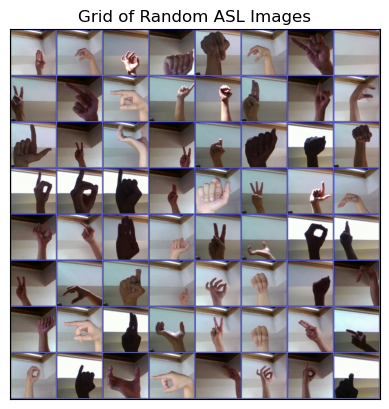

In [10]:
with train_dataset_wrapper.dataset() as dataset:

  dloader = tdata.DataLoader(dataset, 64, True, num_workers=num_workers)

  for i, (x, y) in enumerate(dloader):
    print(f"x shape: { x.shape },\t y shape: {y.shape}")
    plot_grid(x, 8)
    break


## Defining the model


### Defining the Patching Operation

In [11]:
# class PatchEmbedding(nn.Module):

#   def __init__(self, patch_size, embed_size, num_channels=3, **kwargs):
#     super().__init__(**kwargs)
#     self.patch_size = patch_size
#     self.embedding = nn.Conv2d(num_channels, embed_size, patch_size, patch_size)

#   def forward(self, X):
#     """Forward operation

#     Args:
#         X (Tensor): it is of shape `(B, C, H, W)`

#     Returns:
#       Tensor of shape: `(B, N, embed_size)`
#     """

#     # --- the below commented code is useful for when we use patchify and then `Linear` layer to get embeddings --- 
    
#     # reshape into `(B, C, N, N, patch_size, patch_size)`
#     # where N is the number of patches in one dimension
#     X = X.unfold(-2, self.patch_size, self.patch_size).unfold(-2, self.patch_size, self.patch_size)
#     X = X.flatten(2, 3)

#     batch_size, N_dim = X.size(0), X.size(2)

#     # returns tensor of shape: `(B, N, P^2 * C)`
#     X = X.reshape((batch_size, N_dim, -1))
#     X = X.flatten(1)

#     # shape: `(B, N, embed_size)`
#     X = self.embedding(X)

#     return X


In [12]:
class PatchEmbedding(nn.Module):

  def __init__(self, img_size, patch_size, embed_size, num_channels=3, **kwargs):
    """
    Performs the following operations:
      1. Divides into patches using `Conv2d`
      2. Flattens the patches
      3. Prepends BERT `cls` token which is learnable
      4. Adds 2D learnable positional encoding.
    """

    super().__init__(**kwargs)
    self.patch_size = patch_size
    self.embedding = nn.Conv2d(num_channels, embed_size, patch_size, patch_size)

    # token will obviously have shape of the embedding vector
    self.cls = nn.Parameter(torch.randn(1, 1, embed_size))

    # learned positional encoding
    num_patches = ( img_size // patch_size ) ** 2
    self.positional = nn.Parameter(torch.randn(num_patches + 1, embed_size))

  def forward(self, X):
    """Forward operation

    Args:
        X (Tensor): it is of shape `(B, C, H, W)`

    Returns:
      Tensor of shape: `(B, N + 1, embed_size)`
    """

    # --- using convolutional layers as an embedding ---

    # shape: `(B, embed_size, N_sqrt, N_sqrt)`
    X = self.embedding(X)

    # shape: `(B, N, embed_size)`
    X = X.flatten(2).permute(0, 2, 1)

    batch_size, N = X.size(0), X.size(1)
    # we only expand by batch_size because we need to add it per patch anyways
    cls_tensor = self.cls.expand((batch_size, -1, -1))
    
    # shape: `(B, N + 1, embed_size)`
    X = torch.cat((cls_tensor, X), dim=1)

    X += self.positional

    # shape: `(B, N + 1, embed_size)`
    return X


### Defining the Transformer Block

In [13]:
def transpose_qkv(X, num_heads):
  """Transposition for parallel computation of multiple attention heads

  Args:
      X (_type_): shape `(batch_size, num_queries or num_key_value_pairs, num_hiddens)
      num_heads (_type_): _description_
  """
  shape = X.shape

  # shape after: `(batch_size, num_q, num_heads, num_hiddens / num_heads)`
  X = X.reshape(shape[0], shape[1], num_heads, -1)

  # output shape: `(batch_size * num_heads, num_q, num_hiddens / num_heads)`
  return X.reshape(-1, shape[1], X.shape[-1])


def transpose_output(X, num_heads):
  """Reverse the operation of `transpose_qkv`

  Args:
      X (_type_): _description_
      num_heads (_type_): _description_
  """
  shape = X.shape

  # shape after: `(batch_size, num_q, num_heads, num_hiddens / num_heads)`
  X = X.reshape(-1, shape[1], num_heads, shape[-1])

  # output shape: `(batch_size, num_q, num_hiddens)`
  return X.reshape(X.shape[0], shape[1], -1)


In [14]:
class ScaledDotProductAttention(nn.Module):

  def __init__(self, dropout, **kwargs):
    super(ScaledDotProductAttention, self).__init__(**kwargs)

    self.dropout = nn.Dropout(dropout)

  def forward(self, queries: Tensor, keys: Tensor, values: Tensor):
    """Feed Forward stage

    Args:
        queries (Tensor): shape `(batch_size, num_queries, d)`
        keys (Tensor): shape `(batch_size, num_keys, d)`
        values (Tensor): shape `(batch_size, num_keys, v)`
    """

    d = queries.size(-1)
    # scores has shape: `(batch_size, num_queries, num_keys)`
    scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)

    self.attention_weights = torch.nn.functional.softmax(scores, dim=-1)

    # returns matrix of shape: `(batch_size, num_queries, v)`
    return torch.bmm(self.dropout(self.attention_weights), values)


In [15]:
class MultiHeadAttention(nn.Module):

  def __init__(self, key_size, query_size, value_size, num_hiddens, num_heads, dropout, bias=False, **kwargs):
    super().__init__(**kwargs)
    self.num_heads = num_heads

    self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
    self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
    self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)

    self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)

    self.attention = ScaledDotProductAttention(dropout)

  def forward(self, keys, values, queries):
    """Perform multihead attention.

    Args:
        keys (_type_): shape `(batch_size, num_queries or num_key_pairs, d_dim)`
        values (_type_): shape `(batch_size, num_queries or num_key_pairs, d_dim)`
        queries (_type_): shape `(batch_size, num_queries or num_key_pairs, d_dim)`

    Returns:
      tensor of shape: `(batch_size, num_q, num_hiddens)`
    """

    # shape: `(batch_size * num_heads, num_q, num_hiddens / num_heads)`
    queries = transpose_qkv(self.W_q(queries), self.num_heads)
    keys = transpose_qkv(self.W_k(keys), self.num_heads)
    values = transpose_qkv(self.W_v(values), self.num_heads)

    output = self.attention(queries, keys, values)

    # shape: `(batch_size, num_q, num_hiddens)`
    concat_output = transpose_output(output, self.num_heads)

    # shape: `(batch_size, num_q, num_hiddens)`
    return self.W_o(concat_output)

In [16]:
class FeedForwardBlock(nn.Module):

  def __init__(self, num_hiddens, dropout, expansion=4, **kwargs):
    super().__init__(**kwargs)

    self.ff = nn.Sequential(
      nn.Linear(num_hiddens, expansion * num_hiddens),
      nn.GELU(),
      nn.Dropout(dropout),
      nn.Linear(expansion * num_hiddens, num_hiddens)
    )

  def forward(self, X):
    return self.ff(X)

In [43]:
class TransformerBlock(nn.Module):

  def __init__(self, key_size, query_size, value_size, num_hiddens, num_heads, embed_size, dropout, bias=False, **kwargs):
    super().__init__(**kwargs)

    self.ln1 = nn.LayerNorm(embed_size)
    self.ln2 = nn.LayerNorm(num_hiddens)
    self.mha = MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout, bias=bias)
    self.mlp = FeedForwardBlock(num_hiddens, dropout)

  def forward(self, X):
    """Forward method for 1 transformer block

    Args:
        X (_type_): shape `(batch_size, N + 1, embed_size)
    """

    normed_X = self.ln1(X)

    # shape: `(batch_size, query_size, num_hiddens)`
    X = self.mha(normed_X, normed_X, normed_X) + X

    normed_X = self.ln2(X)
    
    # shape: `(batch_size, query_size, num_hiddens)`
    X = self.mlp(normed_X) + X

    # shape: `(batch_size, query_size, num_hiddens)`
    return X


In [44]:
class Transformers(nn.Sequential):

  def __init__(self, num_blocks, num_heads, embed_size, dropout, bias=False, **kwargs):
    super().__init__(
        *[TransformerBlock(embed_size, embed_size, embed_size,
                         embed_size, num_heads, embed_size, dropout, bias=bias) for _ in range(num_blocks)]
    )


In [45]:
class ClassificationHead(nn.Module):
  def __init__(self, embed_size, num_classes, dropout, expansion=2):
    # super().__init__(
    #     nn.LayerNorm(embed_size),
    #     nn.Linear(embed_size, expansion * embed_size),
    #     nn.Tanh(),
    #     nn.Dropout(dropout),
    #     nn.Linear(expansion * embed_size, num_classes),
    #     nn.Softmax(-1)
    # )

    super().__init__()
    self.ff = nn.Sequential(
        nn.LayerNorm(embed_size),
        nn.Linear(embed_size, expansion * embed_size),
        nn.Tanh(),
        nn.Dropout(dropout),
        nn.Linear(expansion * embed_size, num_classes),
        nn.Softmax(-1)
    )

  def forward(self, X):
    return self.ff(X)

In [20]:
ln = nn.LayerNorm(2)
bn = nn.BatchNorm1d(2)

X = torch.tensor([[1, 2], [2, 3]], dtype=torch.float32)

print(f"Variance and mean: {torch.var_mean(X[0, :], False)}")
print(f"Layer Norm: {ln(X)},\nBatch Norm: {bn(X)}")

Variance and mean: (tensor(0.2500), tensor(1.5000))
Layer Norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>),
Batch Norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


### Defining the Full Model

In [46]:
class VisionTransformer(nn. Module):

  def __init__(self, num_classes, img_size, patch_size, D, num_heads, num_blocks, dropout, bias=False, **kwargs):
    super().__init__(**kwargs)

    self.patch_embedding = PatchEmbedding(img_size, patch_size, D)
    self.D = D

    self.transformers = Transformers(
        num_blocks, num_heads, D, dropout, bias=bias)

    self.classifer = ClassificationHead(D, num_classes, dropout)

  def forward(self, X):
    """Complete forward method for the ViT model

    Args:
        X (Tensor): of shape `(B, C, H, W)`
    """

    # has shape: `(B, N + 1, self.D)`
    X = self.patch_embedding(X)

    # has shape: `(B, D, D)`
    X = self.transformers(X)

    # we get the first output from all of the transformer blocks. We will pass it through a classifier
    # has shape: `(B, D)`
    z0 = X[:, 0, :]

    return self.classifer(z0)


In [47]:
a = torch.randn(2, 3, 128, 128)
# (a.unfold(-2, 16, 16).unfold(-2, 16, 16)).shape
VisionTransformer(num_classes, img_size, 16, 512, 8, 2, 0.5)(a).shape

torch.Size([2, 29])

In [ ]:
a = torch.tensor([1, 2, 3])
a.expand((3, -1))

tensor([[1, 2, 3],
        [1, 2, 3],
        [1, 2, 3]])